In [1]:
%matplotlib widget
import sys, os, struct
import hdf5plugin
import h5py
import bitshuffle
import fabio
import numpy
from matplotlib.pyplot import subplots

In [2]:
filename = "eiger_0007.h5"

In [3]:
#Read first frame 
with fabio.open(filename) as f:
    reference = f.data

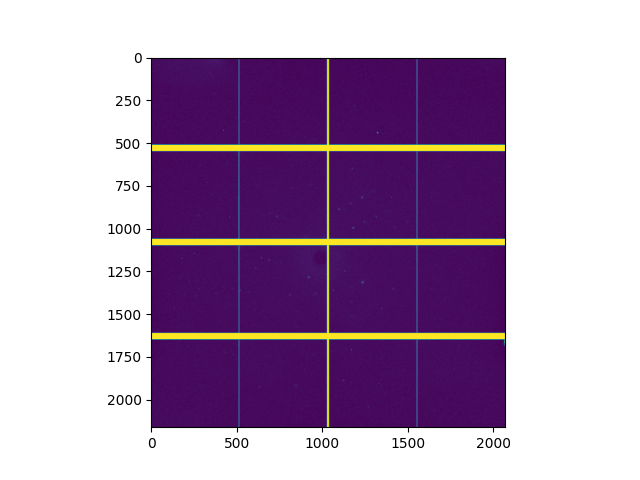

In [4]:
fig,ax = subplots()
ax.imshow(numpy.log1p(reference))

In [5]:
#read one chunk:
with h5py.File(filename, "r") as h:
    ds = h["/entry_0000/measurement/data"]
    #for i in range(ds.id.get_num_chunks()):
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(0).chunk_offset)
print(filter_mask)
print(len(chunk), "Compression rate:", reference.nbytes/len(chunk))

0
1626299 Compression rate: 10.996787183660569


In [6]:
def decompress_bslz4_chunk(payload, dtype, chunk_shape):
    """This function decompresses ONE chunk with bitshuffle-LZ4. 
    The library needs to be compiled without OpenMP when using threads !
    
    :param payload: string with the compressed data as read by h5py.
    :param dtype: data type of the stored content
    :param chunk_shape: shape of one chunk
    :return: decompressed chunk"""
    total_nbytes, block_nbytes = struct.unpack(">QI", payload[:12])
    block_size = block_nbytes // dtype.itemsize

    arr = numpy.frombuffer(payload, dtype=numpy.uint8, offset=12)  # No copy here
    chunk_data = bitshuffle.decompress_lz4(arr, chunk_shape, dtype, block_size)
    return chunk_data

In [7]:
obt1 = decompress_bslz4_chunk(chunk, reference.dtype, reference.shape)
numpy.allclose(obt1, reference)

True

In [8]:
total_nbytes, block_nbytes = struct.unpack(">QI", chunk[:12])
block_size = block_nbytes // reference.dtype.itemsize
total_nbytes, block_nbytes, block_size

(17884064, 0, 0)

In [9]:
arr = numpy.frombuffer(chunk, dtype=numpy.uint8, offset=12)  # No copy here

In [10]:
arr

array([0, 0, 2, ..., 0, 0, 0], dtype=uint8)

In [11]:
bitshuffle.decompress_lz4(arr, reference.shape, reference.dtype, 0)

array([[ 1,  1,  2, ...,  0,  1,  5],
       [ 1,  2,  3, ...,  2,  3,  2],
       [ 1,  1,  1, ...,  0,  1,  0],
       ...,
       [ 1,  2,  2, ...,  0,  0,  0],
       [ 0,  0,  3, ...,  1,  1,  4],
       [10,  6,  5, ...,  2,  4,  1]], dtype=uint32)

In [12]:
import lz4.block, lz4.frame

In [13]:
numpy.frombuffer(chunk[12:16], dtype=">u4")

array([765], dtype=uint32)

In [14]:
blocks = {}
pos = 12
while pos+4<len(chunk):
    l = struct.unpack(">I", chunk[pos:pos+4])[0]
    blocks[(pos+4, pos+4+l)] = chunk[pos+4:pos+4+l]
    pos+=4+l

In [15]:
print(len(blocks))
list(blocks.keys())[:10]

2184


[(16, 781),
 (785, 1559),
 (1563, 2334),
 (2338, 3124),
 (3128, 3901),
 (3905, 4688),
 (4692, 5478),
 (5482, 6242),
 (6246, 7026),
 (7030, 7812)]

In [16]:
len(blocks)*2048*4, reference.nbytes

(17891328, 17884064)

In [17]:
dst = numpy.empty(2048, "uint32")
src = numpy.frombuffer(bytearray(blocks[(16,781)]), dtype="uint8")
bitshuffle.ext.py_LZ4_decompress_safe(src, dst, 781-16, 2048*4)

8192

In [18]:
dst

array([2894201859, 1748287859,      86149, ...,          0,          0,
                0], dtype=uint32)

In [19]:
2048/32

64.0

In [20]:
dst[:64]

array([2894201859, 1748287859,      86149,  159998001, 1875417473,
       2976862725, 4089780612, 1262491383, 3816568663,  890393690,
       3983303407, 1587580191,  471278264,  823231783, 1023954456,
       3758098822,   13107207, 3489786000,  926163012, 1087871252,
        275349516,  604372995, 2910644383, 1611792771, 2304645548,
       2878079270, 2231437568,  574627848, 1128685059,  461134992,
        490849153,   33556049, 2962227185,  135276546, 1611205187,
       1087379096,   18169093, 2852267300,   13247232,   37422785,
       1074058241, 1662902328,   17043888,  808259821,  345645364,
       1355780480, 3693137192,  273561776,  432930848,  686350018,
        640322111,  556890196,  260801572, 1482902857,  404558861,
         68849579, 3227099934, 1195486768,  495977049,  321521546,
       2165039442,  302749027, 2585837606, 1193357826], dtype=uint32)

In [21]:
dst[64:128]

array([3355494436,  272701824,  118921466, 4150377452,   26323488,
         54006118, 3476906576, 2550746368, 2284911152,   89015025,
       2327138195, 4213603320, 1074457027, 2620819146, 2958033409,
       1891744188, 2706081158,    2375904, 2181562506,   50636801,
        536973312, 1615334529,  439111714,   17137664, 2155872400,
        271713345, 3363964544, 1098912007,  612376848, 3758162176,
       2155872322, 2986463232, 3233873919,   14685185,     131073,
         25168193,          2,  272891912,   19922960, 2147483648,
             2784, 2156032072,  604112896,   58722320,    1052736,
       2156209152,  152306187, 3092258818,  488624233,   10552278,
        273959842, 2424406074, 2147749952,   68158606, 1073918348,
       3221488768,      10474,  293781600, 2357102017,   68182016,
         82351268,  819072513,   84002320,  536909338], dtype=uint32)

In [22]:
dst[128:192]

array([    262464, 1073741824, 2147483648,    1196288, 2416050496,
        134481920,     131074,          0,   67175424, 3266642944,
       3293085696,   85005313,   52762116,       6148,          0,
                0,    4194310,      49152,          0,     131080,
                0, 1073807360,   67403776, 2147483648,          0,
                0,  268435456,          0,          0,          0,
        335544320,       1024,      65520,          0,          0,
                0,    2097152,         16,          0,   16777216,
       2147483648,   16777216,      65600,     262144,        128,
              512,    2621440,          4,  281968640,    4194816,
                0, 1077936128,        768,        640,  536870912,
          1048576,       4096,          0,     524290,    4456452,
          1050624,         64,          0,     133120], dtype=uint32)

In [23]:
abs(bitshuffle.ext.bitunshuffle(dst, 2048) - reference.ravel()[:2048]).max()

0

In [64]:
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
import pyopencl
from pyopencl import array as cla
ctx = pyopencl.create_some_context(interactive=0)
queue = pyopencl.CommandQueue(ctx)
chunk_d = cla.to_device(queue, numpy.frombuffer(chunk, dtype=numpy.uint8))
size = numpy.uint64(len(chunk_d))
max_blocks = numpy.uint32(8000);
block_position = numpy.zeros(max_blocks, dtype="uint64")
block_position_d = cla.to_device(queue, block_position)
nblock = numpy.zeros(1, dtype="uint32")
nblock_d = cla.to_device(queue, nblock)
src = open("bitshuffle.cl").read()
prg = pyopencl.Program(ctx, src).build()

In [65]:
prg.lz4_unblock(queue, (1,), (1,),
                chunk_d.data,
                size,
                block_position_d.data,
                max_blocks,
                nblock_d.data).wait()
                

455 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [66]:
numpy.frombuffer(chunk_d.get()[:8], ">Q"), numpy.frombuffer(chunk_d.get()[8:12], ">I"), numpy.frombuffer(chunk_d.get()[12:16], ">I")

(array([17884064], dtype=uint64),
 array([0], dtype=uint32),
 array([765], dtype=uint32))

In [67]:
nblock_d.get()

array([2184], dtype=uint32)

In [68]:
block_position_d.get()

array([  16,  785, 1563, ...,    0,    0,    0], dtype=uint64)

In [69]:
ctx

<pyopencl.Context at 0x55dc0b5c3580 on <pyopencl.Device 'NVIDIA RTX A5000' on 'NVIDIA CUDA' at 0x55dc07dee2f0>>

In [70]:
destination = numpy.zeros(2048*nblock_d.get()[0], dtype="uint32")
destination_d = cla.to_device(queue, destination.view("uint8"))

In [71]:
numpy.frombuffer(lz4.block.decompress(chunk[16:781], 2048*4, False), "uint32")

array([2894201859, 1748287859,      86149, ...,          0,          0,
                0], dtype=uint32)

In [72]:
(reference.nbytes/8192+1)//1

2184.0

In [73]:
2048*4*.04

327.68

In [74]:
wg = int((reference.nbytes/8192+1)//1)
prg.lz4_decompress_block(queue, (wg*32,), (32,),
                        chunk_d.data,
                        destination_d.data,
                        block_position_d.data,
                        size).wait()